In [1]:
import numpy as np
import pandas as pd

import plotly.graph_objs as go
from plotly.offline import init_notebook_mode, plot, iplot
init_notebook_mode(connected=True)

from statsmodels.stats.outliers_influence import variance_inflation_factor

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import sklearn
from sklearn.model_selection import train_test_split, RandomizedSearchCV, GridSearchCV
from sklearn.ensemble import RandomForestClassifier

from sklearn.metrics import roc_auc_score, roc_curve, auc, confusion_matrix, classification_report, accuracy_score

from xgboost import XGBClassifier

In [2]:
data = pd.read_csv('data/nhanes32006data.csv')

In [3]:
data.head()

,Unnamed: 0,age,agestrat,sex,race,ses,smokehx,bmi,obese,htnhx,...,higlu,hba1c,dm,hf,stroke,mi,fasttime,fast,mortstat,PERMTH_INT
0,1,21.750000,21-35,male,non hispanic black,0.641,yes,25.5,no,hypertensive,...,no,5.3,no,no,no,no,6.52,no,alive,203.0
1,2,32.000000,21-35,female,non hispanic black,4.803,yes,23.4,yes,no,...,no,4.6,no,no,no,no,6.12,no,alive,201.0
2,3,48.583333,35-50,female,hispanic,3.747,no,27.6,yes,no,...,no,5.3,no,no,no,no,13.73,no,alive,201.0
3,4,35.666667,35-50,male,hispanic,5.406,yes,29.4,yes,hypertensive,...,no,4.6,no,no,no,no,15.45,no,alive,196.0
4,5,48.500000,35-50,male,non hispanic black,1.676,no,25.0,no,no,...,yes,9.1,diabetes,no,no,no,1.85,yes,alive,190.0


In [4]:
data.shape

(18414, 33)

In [5]:
required_columns = ['obese', 'uralb', 'trig', 'hdl', 'chol', 'hldhx', 'htnhx', 'sbp', 'dbp', 'bmi', 'smokehx', 'ses', 'race', 'sex', 'age', 'hf', 'stroke', 'mi', 'hba1c']
target = "mortstat"

In [6]:
data[required_columns].dtypes

obese       object
uralb      float64
trig       float64
hdl        float64
chol       float64
hldhx      float64
htnhx       object
sbp        float64
dbp        float64
bmi        float64
smokehx     object
ses        float64
race        object
sex         object
age        float64
hf          object
stroke      object
mi          object
hba1c      float64
dtype: object

In [7]:
data = data[required_columns + [target]]

In [8]:
data.head()

,obese,uralb,trig,hdl,chol,hldhx,htnhx,sbp,dbp,bmi,smokehx,ses,race,sex,age,hf,stroke,mi,hba1c,mortstat
0,no,5.8,174.0,38.0,268.0,1.0,hypertensive,120.0,67.0,25.5,yes,0.641,non hispanic black,male,21.750000,no,no,no,5.3,alive
1,yes,2.2,84.0,55.0,160.0,1.0,no,126.0,86.0,23.4,yes,4.803,non hispanic black,female,32.000000,no,no,no,4.6,alive
2,yes,1.6,98.0,66.0,236.0,2.0,no,131.0,73.0,27.6,no,3.747,hispanic,female,48.583333,no,no,no,5.3,alive
3,yes,8.5,109.0,43.0,225.0,2.0,hypertensive,130.0,82.0,29.4,yes,5.406,hispanic,male,35.666667,no,no,no,4.6,alive
4,no,11.3,94.0,51.0,260.0,1.0,no,120.0,70.0,25.0,no,1.676,non hispanic black,male,48.500000,no,no,no,9.1,alive


In [9]:
data.shape

(18414, 20)

In [10]:
data = data[(data['age'] >= 45 ) & (data['age'] <= 65)]

In [11]:
data.shape

(4545, 20)

Remove patients with mi or hf or stroke

In [12]:
data = data[(data['hf'] != 'yes') & (data['stroke'] != 'yes') & (data['mi'] != 'yes')]
data.shape

(4133, 20)

Read the number of nan values

In [13]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4133 entries, 2 to 18407
Data columns (total 20 columns):
obese       3746 non-null object
uralb       3746 non-null float64
trig        3621 non-null float64
hdl         3600 non-null float64
chol        3627 non-null float64
hldhx       4024 non-null float64
htnhx       4114 non-null object
sbp         3741 non-null float64
dbp         3740 non-null float64
bmi         3767 non-null float64
smokehx     4133 non-null object
ses         4133 non-null float64
race        4133 non-null object
sex         4133 non-null object
age         4133 non-null float64
hf          4131 non-null object
stroke      4131 non-null object
mi          4073 non-null object
hba1c       3667 non-null float64
mortstat    4129 non-null object
dtypes: float64(11), object(9)
memory usage: 678.1+ KB


Percentage of missing data

In [14]:
data.isna().any(axis = 1).sum()

738

In [15]:
100*data.isna().any(axis = 1).sum()/data.shape[0]

17.85627873215582

In [16]:
data['hldhx'] = data['hldhx'].astype(object)

In [17]:
categorical_columns = data.select_dtypes('object').columns
categorical_columns

Index(['obese', 'hldhx', 'htnhx', 'smokehx', 'race', 'sex', 'hf', 'stroke',
       'mi', 'mortstat'],
      dtype='object')

In [18]:
numerical_columns = list(set(data.columns) - set(categorical_columns))
numerical_columns

['sbp', 'age', 'dbp', 'bmi', 'uralb', 'trig', 'chol', 'hdl', 'ses', 'hba1c']

Missing data in Categorical Columns

In [19]:
def count_empty(data, columns):
    return data[columns].isna().sum()

Percentage of missing data in each column

In [20]:
def percentage_empty(data, columns):
    return 100*data[columns].isna().sum()/data.shape[0]

In [21]:
percentage_empty(data, categorical_columns)

obese       9.363658
hldhx       2.637309
htnhx       0.459714
smokehx     0.000000
race        0.000000
sex         0.000000
hf          0.048391
stroke      0.048391
mi          1.451730
mortstat    0.096782
dtype: float64

In [22]:
data.loc[data['obese'].isnull(), 'obese'] = "Not_Available"
data.loc[data['htnhx'].isnull(), 'htnhx'] = "Not_Available"
data.loc[data['mi'].isnull(), 'mi'] = "Not_Available"

In [23]:
percentage_empty(data, categorical_columns)

obese       0.000000
hldhx       2.637309
htnhx       0.000000
smokehx     0.000000
race        0.000000
sex         0.000000
hf          0.048391
stroke      0.048391
mi          0.000000
mortstat    0.096782
dtype: float64

In [24]:
count_empty(data, categorical_columns)

obese         0
hldhx       109
htnhx         0
smokehx       0
race          0
sex           0
hf            2
stroke        2
mi            0
mortstat      4
dtype: int64

In [25]:
data['hf'].value_counts(dropna = False)

no     4131
NaN       2
Name: hf, dtype: int64

In [26]:
data['stroke'].value_counts(dropna = False)

no     4131
NaN       2
Name: stroke, dtype: int64

In [27]:
data.loc[data['hf'].isna(), 'hf'] = 'no'
data.loc[data['stroke'].isna(), 'stroke'] = 'no'

In [28]:
data.dropna(subset=['mortstat'], inplace=True)

In [29]:
data.shape

(4129, 20)

In [30]:
count_empty(data, categorical_columns)

obese         0
hldhx       108
htnhx         0
smokehx       0
race          0
sex           0
hf            0
stroke        0
mi            0
mortstat      0
dtype: int64

Missing values in Numeric columns

In [31]:
data[numerical_columns].head()

,sbp,age,dbp,bmi,uralb,trig,chol,hdl,ses,hba1c
2,131.0,48.583333,73.0,27.6,1.6,98.0,236.0,66.0,3.747,5.3
4,120.0,48.500000,70.0,25.0,11.3,94.0,260.0,51.0,1.676,9.1
9,128.0,56.750000,73.0,37.0,0.4,171.0,156.0,42.0,5.690,5.0
12,117.0,50.166667,74.0,25.1,1.8,204.0,244.0,47.0,3.416,5.9
14,155.0,48.416667,91.0,37.5,105.0,479.0,212.0,30.0,0.622,5.7


In [32]:
count_empty(data, numerical_columns)

sbp      390
age        0
dbp      391
bmi      364
uralb    385
trig     510
chol     504
hdl      531
ses        0
hba1c    464
dtype: int64

In [33]:
data[numerical_columns].describe()

,sbp,age,dbp,bmi,uralb,trig,chol,hdl,ses,hba1c
count,3739.000000,4129.000000,3738.000000,3765.000000,3744.000000,3619.000000,3625.000000,3598.000000,4129.000000,3665.000000
mean,130.025675,55.011484,78.111557,28.129907,15954.355823,165.497099,219.889931,51.423013,89558.771615,5.820518
std,17.997470,6.005141,9.758558,5.662946,117850.620796,138.369686,43.785812,16.624608,267585.441783,1.334759
min,81.000000,45.000000,44.000000,13.300000,0.400000,27.000000,59.000000,12.000000,0.000000,3.300000
25%,118.000000,49.750000,72.000000,24.200001,2.700000,92.000000,191.000000,40.000000,1.426000,5.200000
50%,128.000000,55.000000,77.000000,27.200001,6.500000,130.000000,217.000000,48.000000,2.812000,5.500000
75%,140.000000,60.500000,84.000000,31.100000,15.200000,193.000000,245.000000,60.000000,4.917000,5.900000
max,237.000000,65.000000,124.000000,54.299999,888888.000000,3616.000000,464.000000,191.000000,888888.000000,16.100000


In [34]:
data.loc[data['uralb'] == 888888.000, 'uralb'] = np.nan
data.loc[data['ses'] == 888888.000, 'ses'] = np.nan

In [35]:
data[numerical_columns].describe()

,sbp,age,dbp,bmi,uralb,trig,chol,hdl,ses,hba1c
count,3739.000000,4129.000000,3738.000000,3765.000000,3677.000000,3619.000000,3625.000000,3598.000000,3713.000000,3665.000000
mean,130.025675,55.011484,78.111557,28.129907,48.303563,165.497099,219.889931,51.423013,2.897925,5.820518
std,17.997470,6.005141,9.758558,5.662946,365.342982,138.369686,43.785812,16.624608,1.977917,1.334759
min,81.000000,45.000000,44.000000,13.300000,0.400000,27.000000,59.000000,12.000000,0.000000,3.300000
25%,118.000000,49.750000,72.000000,24.200001,2.600000,92.000000,191.000000,40.000000,1.302000,5.200000
50%,128.000000,55.000000,77.000000,27.200001,6.300000,130.000000,217.000000,48.000000,2.535000,5.500000
75%,140.000000,60.500000,84.000000,31.100000,14.400000,193.000000,245.000000,60.000000,4.191000,5.900000
max,237.000000,65.000000,124.000000,54.299999,12400.000000,3616.000000,464.000000,191.000000,11.290000,16.100000


Data shows outliers in trig and uralb

In [36]:
np.nanpercentile(data['trig'], 99)

713.5600000000013

In [37]:
np.nanpercentile(data['uralb'], 99.5)

1768.199999999988

In [38]:
data.loc[data['trig'] > np.nanpercentile(data['trig'], 99), 'trig'] = np.nanpercentile(data['trig'], 99)

In [39]:
data.loc[data['uralb'] > np.nanpercentile(data['uralb'], 99.5), 'uralb'] = np.nanpercentile(data['uralb'], 99.5)

In [40]:
data.describe()

,uralb,trig,hdl,chol,sbp,dbp,bmi,ses,age,hba1c
count,3677.000000,3619.000000,3598.000000,3625.000000,3739.000000,3738.000000,3765.000000,3713.000000,4129.000000,3665.000000
mean,35.421267,162.676353,51.423013,219.889931,130.025675,78.111557,28.129907,2.897925,55.011484,5.820518
std,164.972488,113.660564,16.624608,43.785812,17.997470,9.758558,5.662946,1.977917,6.005141,1.334759
min,0.400000,27.000000,12.000000,59.000000,81.000000,44.000000,13.300000,0.000000,45.000000,3.300000
25%,2.600000,92.000000,40.000000,191.000000,118.000000,72.000000,24.200001,1.302000,49.750000,5.200000
50%,6.300000,130.000000,48.000000,217.000000,128.000000,77.000000,27.200001,2.535000,55.000000,5.500000
75%,14.400000,193.000000,60.000000,245.000000,140.000000,84.000000,31.100000,4.191000,60.500000,5.900000
max,1768.200000,713.560000,191.000000,464.000000,237.000000,124.000000,54.299999,11.290000,65.000000,16.100000


In [41]:
for column in numerical_columns:
    data.loc[data[column].isna(), column] = data[column].mean()

In [42]:
count_empty(data, numerical_columns)

sbp      0
age      0
dbp      0
bmi      0
uralb    0
trig     0
chol     0
hdl      0
ses      0
hba1c    0
dtype: int64

In [43]:
data.columns

Index(['obese', 'uralb', 'trig', 'hdl', 'chol', 'hldhx', 'htnhx', 'sbp', 'dbp',
       'bmi', 'smokehx', 'ses', 'race', 'sex', 'age', 'hf', 'stroke', 'mi',
       'hba1c', 'mortstat'],
      dtype='object')

In [44]:
data['mortstat'].value_counts()

alive    3281
dead      848
Name: mortstat, dtype: int64

Removing Bivariate

In [45]:
data['mortstat'] = data['mortstat'].map({
    'alive' : 0,
    'dead' : 1
})

In [46]:
data['mortstat'].value_counts(normalize = True)

0    0.794623
1    0.205377
Name: mortstat, dtype: float64

In [47]:
categorical_columns = list(categorical_columns)
categorical_columns.remove('mortstat')

In [48]:
er_data = pd.DataFrame()
for column in categorical_columns:
    groupby_data = data[[column] + ['mortstat']].groupby(column).agg({'mortstat' : ['sum', 'count']})
    groupby_data.columns = ['deaths', 'population']
    groupby_data.reset_index(inplace=True)
    groupby_data['event_rate'] = 100*groupby_data['deaths']/groupby_data['population']
    groupby_data['population_dist'] = 100*groupby_data['population']/ groupby_data['population'].sum()
    groupby_data.columns = ['levels', 'deaths', 'population', 'death_rate', 'population_dist']
    groupby_data['field'] = column
    er_data = er_data.append(groupby_data)
er_data = er_data[['field', 'levels', 'deaths', 'population', 'death_rate', 'population_dist']]

In [49]:
er_data

,field,levels,deaths,population,death_rate,population_dist
0,obese,Not_Available,104,385,27.012987,9.324292
1,obese,no,304,1649,18.435415,39.937031
2,obese,yes,440,2095,21.002387,50.738678
0,hldhx,1,338,1450,23.310345,36.060681
1,hldhx,2,472,2571,18.358615,63.939319
0,htnhx,Not_Available,3,19,15.789474,0.460160
1,htnhx,hypertensive,387,1431,27.044025,34.657302
2,htnhx,no,458,2679,17.095931,64.882538
0,smokehx,no,631,2451,25.744594,59.360620
1,smokehx,yes,217,1678,12.932062,40.639380


Ploting death rates

In [50]:
def plt_event_rate(er_data):
    for field in er_data['field'].unique():
        trace1 = go.Bar(x=list(er_data[er_data['field'] == field]['levels'].values), y=list(er_data[er_data['field'] == field]['population_dist'].values))
        trace2 = go.Scatter(x=list(er_data[er_data['field'] == field]['levels'].values), y=list(er_data[er_data['field'] == field]['death_rate'].values), yaxis='y2')
        data = [trace1, trace2]
        layout = go.Layout(
            title="Double Y axis - "+field.capitalize(),
            yaxis=dict(
                title='Population Distibution'
            ),
            yaxis2=dict(
                title='Death Rate',
                titlefont=dict(
                    color='rgb(148, 103, 189)'
                ),
                tickfont=dict(
                    color='rgb(148, 103, 189)'
                ),
                overlaying='y',
                side='right'
            )
        )
        fig = go.Figure(data=data, layout=layout)
        plot_url = iplot(fig, filename='multiple-axes-double')

In [51]:
plt_event_rate(er_data)

In [52]:
er_data = pd.DataFrame()
for column in numerical_columns:
    data['decile'] = pd.qcut(data[column], q=10, duplicates='drop', labels=False)
    groupby_data = data[['decile'] + ['mortstat']].groupby('decile').agg({'mortstat' : ['sum', 'count']})
    groupby_data.columns = ['deaths', 'population']
    groupby_data.reset_index(inplace=True)
    groupby_data['event_rate'] = 100*groupby_data['deaths']/groupby_data['population']
    groupby_data['population_dist'] = 100*groupby_data['population']/ groupby_data['population'].sum()
    groupby_data.columns = ['levels', 'deaths', 'population', 'death_rate', 'population_dist']
    groupby_data['field'] = column
    er_data = er_data.append(groupby_data)

In [53]:
er_data

,levels,deaths,population,death_rate,population_dist,field
0,0,58,429,13.519814,10.389925,sbp
1,1,53,429,12.354312,10.389925,sbp
2,2,75,472,15.889831,11.431339,sbp
3,3,49,344,14.244186,8.331315,sbp
4,4,79,473,16.701903,11.455558,sbp
5,5,105,390,26.923077,9.445386,sbp
6,6,77,379,20.316623,9.178978,sbp
7,7,94,416,22.596154,10.075079,sbp
8,8,107,407,26.289926,9.857108,sbp
9,9,151,390,38.717949,9.445386,sbp


Plot death rates using numeric columns

In [54]:
plt_event_rate(er_data)

In [55]:
X = data[numerical_columns].values

In [56]:
vif = pd.DataFrame()
vif["VIF Factor"] = [variance_inflation_factor(X, i) for i in range(X.shape[1])]
vif["features"] = numerical_columns
vif

,VIF Factor,features
0,106.217737,sbp
1,64.283385,age
2,93.655568,dbp
3,29.701090,bmi
4,1.102010,uralb
5,4.602459,trig
6,34.836054,chol
7,14.317003,hdl
8,3.399858,ses
9,23.104378,hba1c


In [57]:
def calculate_vif(X, threshold = 15.0):
    variables = list(range(X.shape[1]))
    dropped = True
    while dropped:
        dropped = False
        vif = [variance_inflation_factor(X.iloc[:, variables].values, ix)
               for ix in range(X.iloc[:, variables].shape[1])]
        maxloc = vif.index(max(vif))
        if max(vif) > threshold:
            print('dropping \'' + X.iloc[:, variables].columns[maxloc] +
                  '\' at index: ' + str(maxloc))
            del variables[maxloc]
            dropped = True
    print('Remaining variables:')
    print(X.columns[variables])
    return X.iloc[:, variables]

In [58]:
data_filtered_num = calculate_vif(data[numerical_columns])

dropping 'sbp' at index: 0
dropping 'age' at index: 0
dropping 'dbp' at index: 0
dropping 'chol' at index: 3
dropping 'bmi' at index: 0
Remaining variables:
Index(['uralb', 'trig', 'hdl', 'ses', 'hba1c'], dtype='object')


Correlation on filtered data

In [59]:
data_filtered_num.describe()

,uralb,trig,hdl,ses,hba1c
count,4129.000000,4129.000000,4129.000000,4129.000000,4129.000000
mean,35.421267,162.676353,51.423013,2.897925,5.820518
std,155.678785,106.407991,15.518573,1.875609,1.257508
min,0.400000,27.000000,12.000000,0.000000,3.300000
25%,2.900000,97.000000,41.000000,1.426000,5.200000
50%,7.700000,143.000000,51.000000,2.812000,5.600000
75%,23.600000,179.000000,58.000000,3.855000,5.820518
max,1768.200000,713.560000,191.000000,11.290000,16.100000


In [60]:
data_filtered_num.corr()

,uralb,trig,hdl,ses,hba1c
uralb,1.000000,0.069481,-0.020956,-0.060887,0.146408
trig,0.069481,1.000000,-0.369528,-0.019121,0.178024
hdl,-0.020956,-0.369528,1.000000,0.027850,-0.145770
ses,-0.060887,-0.019121,0.027850,1.000000,-0.128628
hba1c,0.146408,0.178024,-0.145770,-0.128628,1.000000


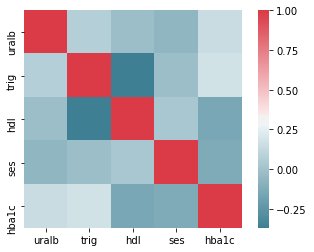

In [61]:
sns.heatmap(data_filtered_num.corr(), cmap=sns.diverging_palette(220, 10, as_cmap=True),square=True)

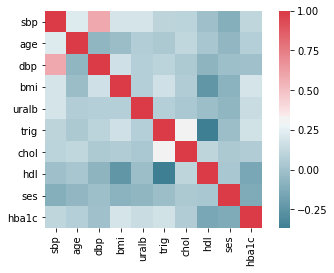

In [62]:
sns.heatmap(data[numerical_columns].corr(), cmap=sns.diverging_palette(220, 10, as_cmap=True),square=True)

In [63]:
data_filtered_cat = pd.get_dummies(data[categorical_columns], drop_first=True)

In [64]:
data_filtered_cat.head()

,obese_no,obese_yes,hldhx_2.0,htnhx_hypertensive,htnhx_no,smokehx_yes,race_multiracial,race_non hispanic black,race_non hispanic white,sex_male,mi_no
2,0,1,1,0,1,0,0,0,0,0,1
4,1,0,0,0,1,0,0,1,0,1,1
9,0,1,1,0,1,0,0,0,0,0,1
12,1,0,1,0,1,1,0,1,0,1,1
14,0,1,0,1,0,0,0,1,0,1,1


In [65]:
model_data = pd.concat((data_filtered_num, data_filtered_cat), axis=1)

In [66]:
model_data.head()

,uralb,trig,hdl,ses,hba1c,obese_no,obese_yes,hldhx_2.0,htnhx_hypertensive,htnhx_no,smokehx_yes,race_multiracial,race_non hispanic black,race_non hispanic white,sex_male,mi_no
2,1.6,98.0,66.0,3.747,5.3,0,1,1,0,1,0,0,0,0,0,1
4,11.3,94.0,51.0,1.676,9.1,1,0,0,0,1,0,0,1,0,1,1
9,0.4,171.0,42.0,5.690,5.0,0,1,1,0,1,0,0,0,0,0,1
12,1.8,204.0,47.0,3.416,5.9,1,0,1,0,1,1,0,1,0,1,1
14,105.0,479.0,30.0,0.622,5.7,0,1,0,1,0,0,0,1,0,1,1


In [67]:
model_data.shape

(4129, 16)

In [68]:
data['mortstat'].shape

(4129,)

Split data into train and test

In [69]:
train_x, test_x, train_y, test_y = train_test_split(model_data, data['mortstat'], test_size = 0.3, random_state = 10)

In [70]:
print(train_x.shape, test_x.shape, train_y.shape, test_y.shape)

(2890, 16) (1239, 16) (2890,) (1239,)


In [71]:
rf_params = { 
    'max_depth': np.arange(2,7),  
    'min_samples_leaf': [0.01, 0.05, 0.1, 0.15, 0.2],
    'n_estimators': [100, 200, 400, 600, 1000], 
    'max_features': [3, 4, 5, 6, 7, 10, 15]
}
rf = RandomForestClassifier(class_weight='balanced', n_jobs=-1, verbose=False, oob_score=True)
random_cv = RandomizedSearchCV(rf, cv=5, param_distributions=rf_params)

In [72]:
random_cv.fit(train_x, train_y)

RandomizedSearchCV(cv=5, error_score='raise-deprecating',
          estimator=RandomForestClassifier(bootstrap=True, class_weight='balanced',
            criterion='gini', max_depth=None, max_features='auto',
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators='warn', n_jobs=-1, oob_score=True,
            random_state=None, verbose=False, warm_start=False),
          fit_params=None, iid='warn', n_iter=10, n_jobs=None,
          param_distributions={'max_depth': array([2, 3, 4, 5, 6]), 'min_samples_leaf': [0.01, 0.05, 0.1, 0.15, 0.2], 'n_estimators': [100, 200, 400, 600, 1000], 'max_features': [3, 4, 5, 6, 7, 10, 15]},
          pre_dispatch='2*n_jobs', random_state=None, refit=True,
          return_train_score='warn', scoring=None, verbose=0)

In [73]:
random_cv.best_params_

{'n_estimators': 400,
 'min_samples_leaf': 0.01,
 'max_features': 3,
 'max_depth': 6}

In [74]:
rf = RandomForestClassifier(class_weight='balanced', n_jobs=-1, verbose=True, **random_cv.best_params_)

In [75]:
rf.fit(train_x, train_y)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 400 out of 400 | elapsed:    0.2s finished


RandomForestClassifier(bootstrap=True, class_weight='balanced',
            criterion='gini', max_depth=6, max_features=3,
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=0.01,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=400, n_jobs=-1, oob_score=False,
            random_state=None, verbose=True, warm_start=False)

In [76]:
test_pred = rf.predict_proba(test_x)[:,1]

[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 176 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 400 out of 400 | elapsed:    0.1s finished


In [77]:
rf.predict_proba(test_x)

[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 176 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 400 out of 400 | elapsed:    0.1s finished


array([[0.63872272, 0.36127728],
       [0.43484274, 0.56515726],
       [0.54159166, 0.45840834],
       ...,
       [0.65748598, 0.34251402],
       [0.78299105, 0.21700895],
       [0.5578036 , 0.4421964 ]])

In [78]:
roc_auc_score(test_y, test_pred)

0.69213013463816

In [79]:
accuracy_score(test_y, rf.predict(test_x))

[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 176 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 400 out of 400 | elapsed:    0.1s finished


0.6642453591606134

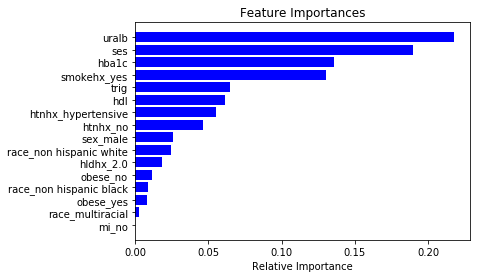

In [80]:
features = model_data.columns
importances = rf.feature_importances_
indices = np.argsort(importances)

plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='b', align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()

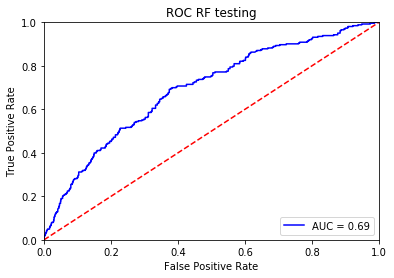

In [81]:
fpr, tpr, threshold = roc_curve(test_y, test_pred)
roc_auc = auc(fpr, tpr)
plt.title('ROC RF testing')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.1s
[Parallel(n_jobs=12)]: Done 176 tasks      | elapsed:    0.1s
[Parallel(n_jobs=12)]: Done 400 out of 400 | elapsed:    0.1s finished


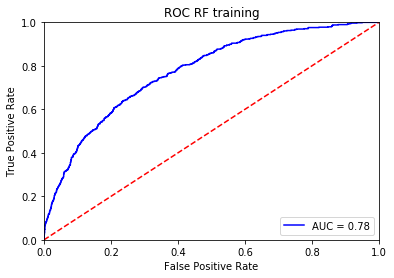

In [82]:
train_pred = rf.predict_proba(train_x)[:,1]
fpr, tpr, threshold = roc_curve(train_y, train_pred)
roc_auc = auc(fpr, tpr)
plt.title('ROC RF training')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 176 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 400 out of 400 | elapsed:    0.1s finished


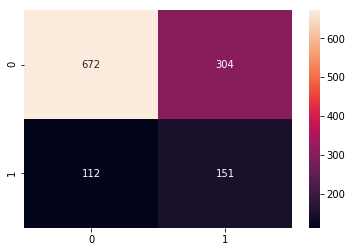

In [83]:
labelname = rf.classes_
sns.heatmap(confusion_matrix(test_y, rf.predict(test_x)), annot=True,  fmt='', xticklabels=labelname, yticklabels=labelname)

In [84]:
print(classification_report(test_y, rf.predict(test_x)))

              precision    recall  f1-score   support

           0       0.86      0.69      0.76       976
           1       0.33      0.57      0.42       263

   micro avg       0.66      0.66      0.66      1239
   macro avg       0.59      0.63      0.59      1239
weighted avg       0.75      0.66      0.69      1239



[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 176 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 400 out of 400 | elapsed:    0.1s finished


In [85]:
xgb_params = { 
    'max_depth': np.arange(3,7),
    'learn_rate' : [0.001, 0.01, 0.0001],
    'gamma': [0.01, 0.05, 0.1, 0.15, 0.2, 0.5, 1],
    'min_child_weight': [1, 2, 3, 4, 5, 6, 7, 10, 15],
    'max_delta_step': [1, 2, 3, 4, 5, 6, 7, 10, 15],
    'subsample' : [0.5, 0.8, 1],
    'colsample_bytree' : [0.25, 0.5, 0.75, 1],
    'n_estimators' : [100,200,500],
    'importance_type' : ["gain", "weight", "cover", "total_gain", "total_cover"]
}
xgb = XGBClassifier(n_jobs=-1, eval_metric=["auc", "error"], class_weight='balanced')
random_cv = RandomizedSearchCV(xgb, cv=5, param_distributions=xgb_params)

In [86]:
random_cv.fit(train_x, train_y)
xgb = XGBClassifier(n_jobs=-1, eval_metric=["auc", "error"], class_weight='balanced', **random_cv.best_params_)

In [87]:
xgb

XGBClassifier(base_score=0.5, booster='gbtree', class_weight='balanced',
       colsample_bylevel=1, colsample_bytree=0.25,
       eval_metric=['auc', 'error'], gamma=1, learn_rate=0.01,
       learning_rate=0.1, max_delta_step=5, max_depth=4,
       min_child_weight=3, missing=None, n_estimators=100, n_jobs=-1,
       nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=0.5)

In [88]:
random_cv.best_params_

{'subsample': 0.5,
 'n_estimators': 100,
 'min_child_weight': 3,
 'max_depth': 4,
 'max_delta_step': 5,
 'learn_rate': 0.01,
 'importance_type': 'cover',
 'gamma': 1,
 'colsample_bytree': 0.25}

In [89]:
xgb.fit(train_x, train_y)
test_pred = xgb.predict_proba(test_x)[:,1]
roc_auc_score(test_y, test_pred)

0.6719051922957053

In [90]:
accuracy_score(test_y, xgb.predict(test_x))

0.7949959644874899

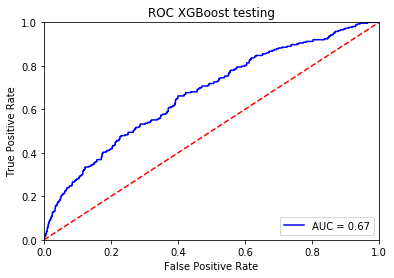

In [91]:
fpr, tpr, threshold = roc_curve(test_y, test_pred)
roc_auc = auc(fpr, tpr)
plt.title('ROC XGBoost testing')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 176 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 400 out of 400 | elapsed:    0.1s finished


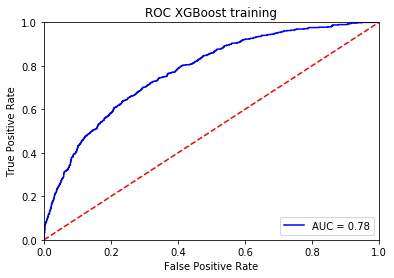

In [92]:
train_pred = rf.predict_proba(train_x)[:,1]
fpr, tpr, threshold = roc_curve(train_y, train_pred)
roc_auc = auc(fpr, tpr)
plt.title('ROC XGBoost training')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

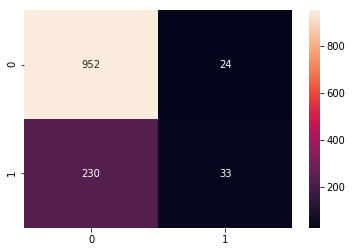

In [93]:
labelname = xgb.classes_
sns.heatmap(confusion_matrix(test_y, xgb.predict(test_x)), annot=True,  fmt='', xticklabels=labelname, yticklabels=labelname)

In [94]:
print(classification_report(test_y, xgb.predict(test_x)))

              precision    recall  f1-score   support

           0       0.81      0.98      0.88       976
           1       0.58      0.13      0.21       263

   micro avg       0.79      0.79      0.79      1239
   macro avg       0.69      0.55      0.54      1239
weighted avg       0.76      0.79      0.74      1239

